In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score
from tqdm import tqdm

# Load the dataset
file_path = '../The_Hofmarcher_Files/CP_count_Hofmarcher.csv'  
data = pd.read_csv(file_path)

# List of assay columns to process (assuming all columns except INCHIKEY and the last 13 columns are assays)
assay_columns = data.columns[1:-13]

# Initialize a list to store results
results = []

# Define a function to calculate a probability score based on the distance from the threshold
def calculate_probability_score(value, threshold):
    return 1 / (1 + np.exp(value - threshold))

# Define threshold range based on the dataset
min_value = data['Cells_Number_Object_Number'].min()
max_value = data['Cells_Number_Object_Number'].max()
thresholds = np.arange(min_value, max_value, 1)

# Process each assay and each threshold
for assay in tqdm(assay_columns):
    # Drop rows with NaNs or -1s in the current assay column or in Cells_Number_Object_Number
    valid_data = data[(data[assay] != -1) & (data[assay].notna())].copy().reset_index(drop=True)

    # Process for each threshold
    for threshold in thresholds:
    
        # Calculate the probability score
        valid_data.loc[:, 'Probability_Score'] = valid_data['Cells_Number_Object_Number'].apply(calculate_probability_score, threshold=threshold)
        # print(valid_data[['Probability_Score']])
        # True values for the assay
        true_values = valid_data[assay] == 1
        predicted_probs = valid_data['Probability_Score']
        predicted_values = valid_data['Probability_Score'] >= 0.5

        # Calculate TP, FP, TN, FN
        TP = np.sum((predicted_values == 1) & (true_values == 1))
        FP = np.sum((predicted_values == 1) & (true_values == 0))
        TN = np.sum((predicted_values == 0) & (true_values == 0))
        FN = np.sum((predicted_values == 0) & (true_values == 1))

        # Calculate metrics
        accuracy = accuracy_score(true_values, predicted_values)
        balanced_accuracy = balanced_accuracy_score(true_values, predicted_values)
        recall = recall_score(true_values, predicted_values, zero_division=0)
        precision = precision_score(true_values, predicted_values, zero_division=0)
        auc = roc_auc_score(true_values, predicted_probs)
        # print(auc)

        # Append the result
        results.append({
            'Assay': assay,
            'Accuracy': accuracy,
            'Balanced Accuracy': balanced_accuracy,
            'Recall': recall,
            'Precision': precision,
            'Threshold': threshold,
            'AUC': auc,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('assay_auc_by_threshold_with_confusion_Hofmarcher.csv', index=False)


100%|██████████| 209/209 [01:29<00:00,  2.34it/s]


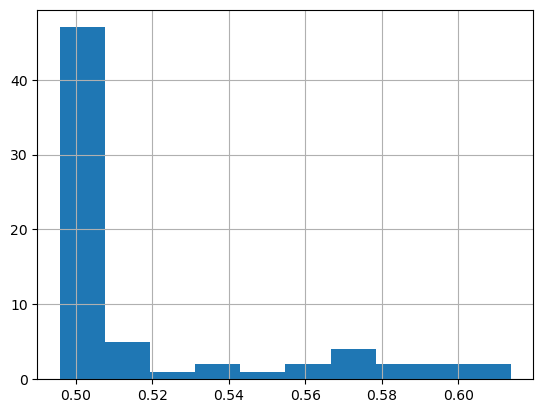

In [3]:
results_df = pd.read_csv('assay_auc_by_threshold_with_confusion_Hofmarcher.csv')

results_df["Threshold"] = results_df["Threshold"].round(2)

results_df[results_df["Assay"]==31]["Balanced Accuracy"].hist()
plt.show()

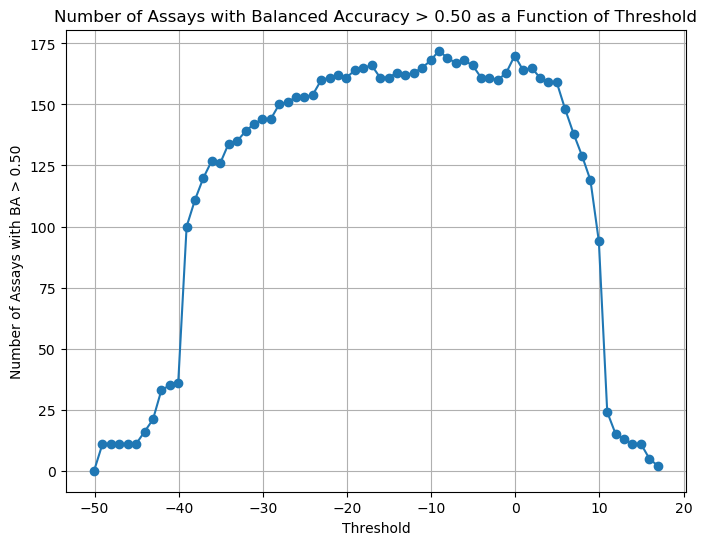

In [4]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.50).sum()).reset_index(name='Assays with BA > 0.50')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.50'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.50 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.50')
plt.grid(True)
plt.show()

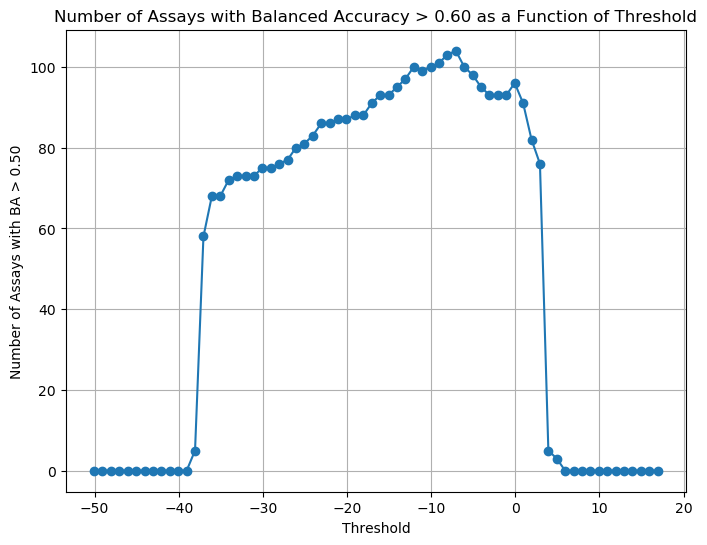

In [5]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.60).sum()).reset_index(name='Assays with BA > 0.60')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.60'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.60 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.50')
plt.grid(True)
plt.show()


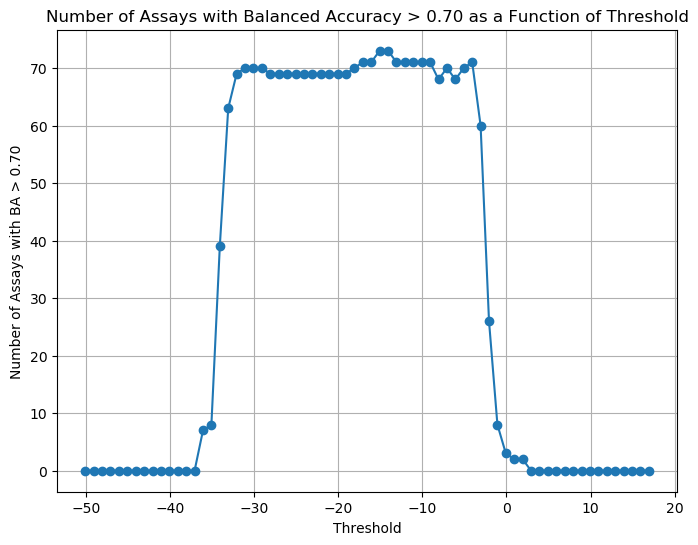

In [6]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.70).sum()).reset_index(name='Assays with BA > 0.70')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.70'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.70 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.70')
plt.grid(True)
plt.show()


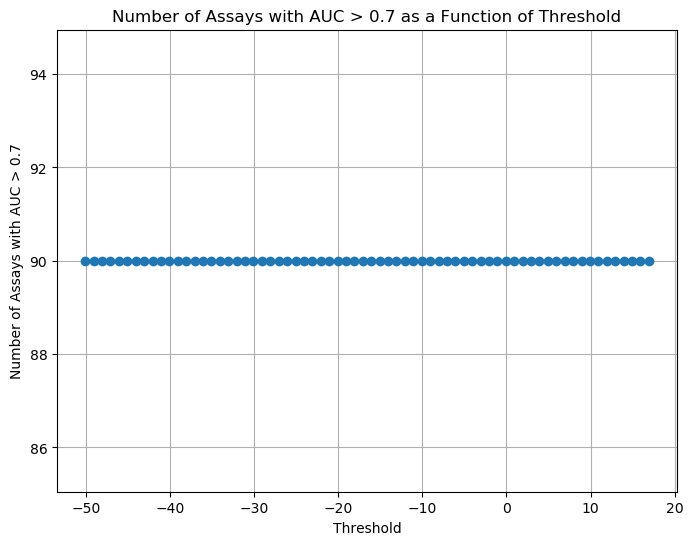

In [7]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['AUC'] > 0.7).sum()).reset_index(name='Assays with AUC>')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with AUC>'], marker='o', linestyle='-')
plt.title('Number of Assays with AUC > 0.7 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with AUC > 0.7')
plt.grid(True)
plt.show()


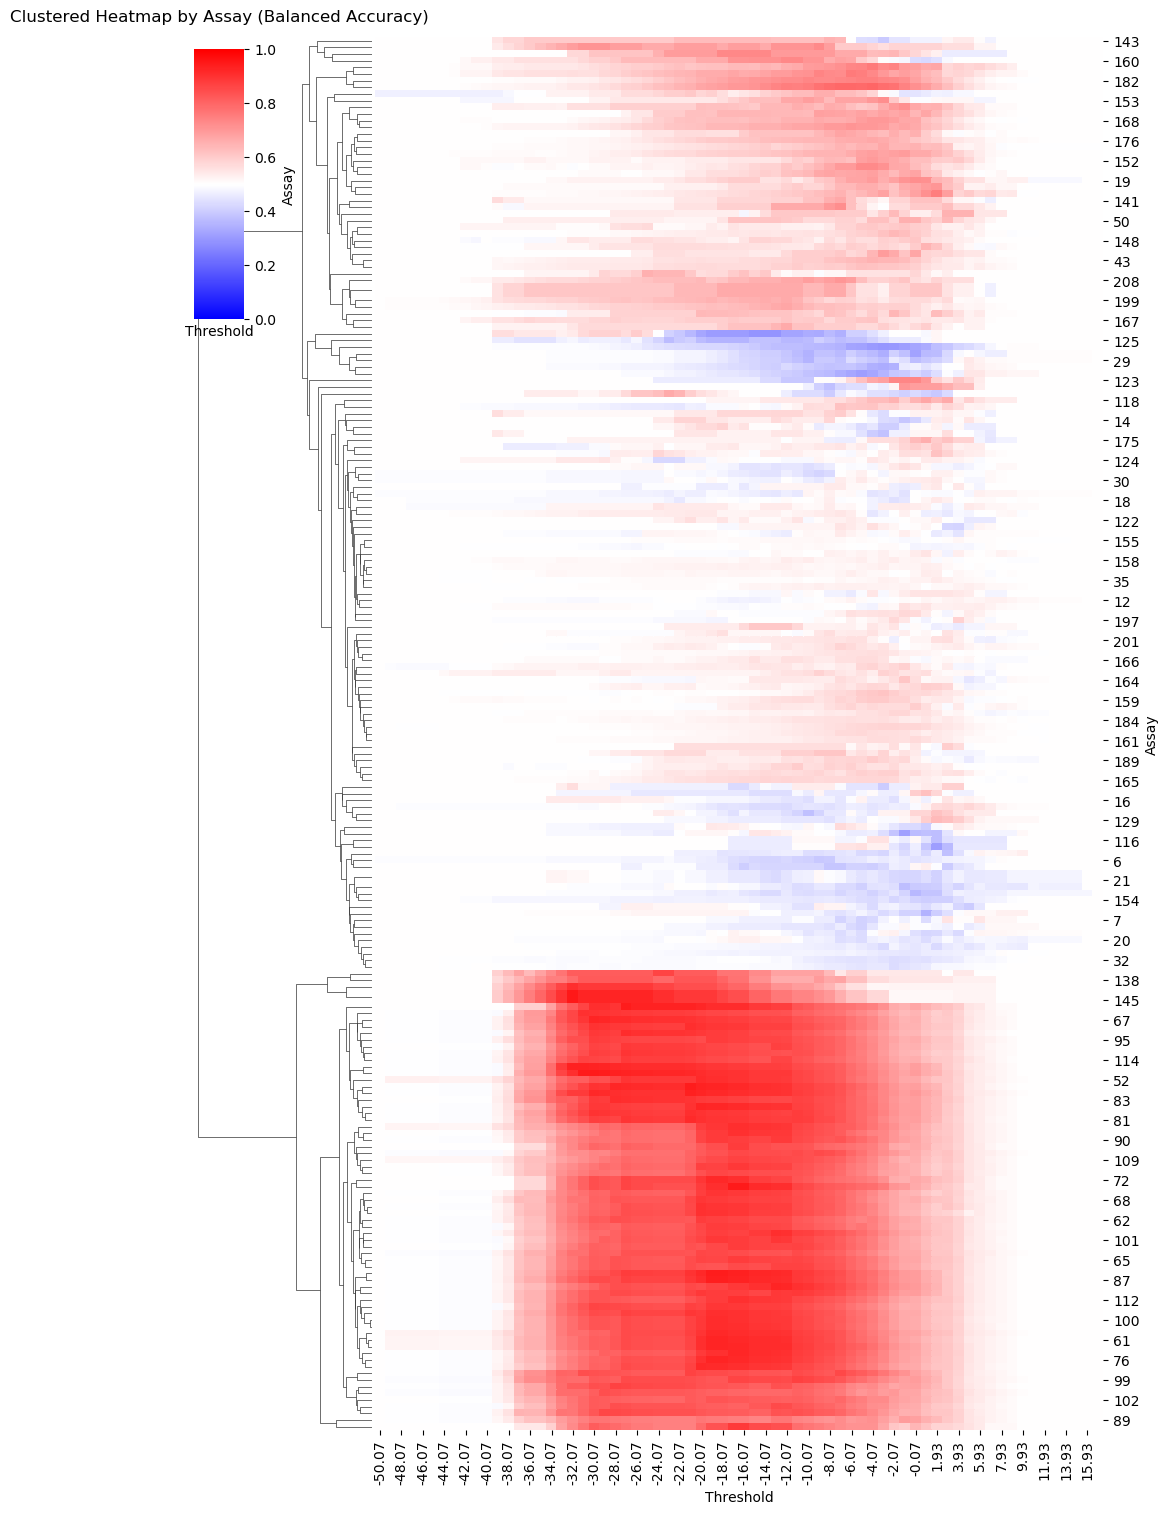

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap, with 'Assay' as rows, 'Threshold' as columns, and 'Balanced Accuracy' as values
heatmap_data = results_df.pivot(index='Assay', columns='Threshold', values='Balanced Accuracy')

# Plot the clustered heatmap with clustering only by Assay (rows)
sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
               row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), method='average',
               center=0.5, vmin=0, vmax=1)

plt.title('Clustered Heatmap by Assay (Balanced Accuracy)', pad=20)
plt.xlabel('Threshold')
plt.ylabel('Assay')
plt.show()


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


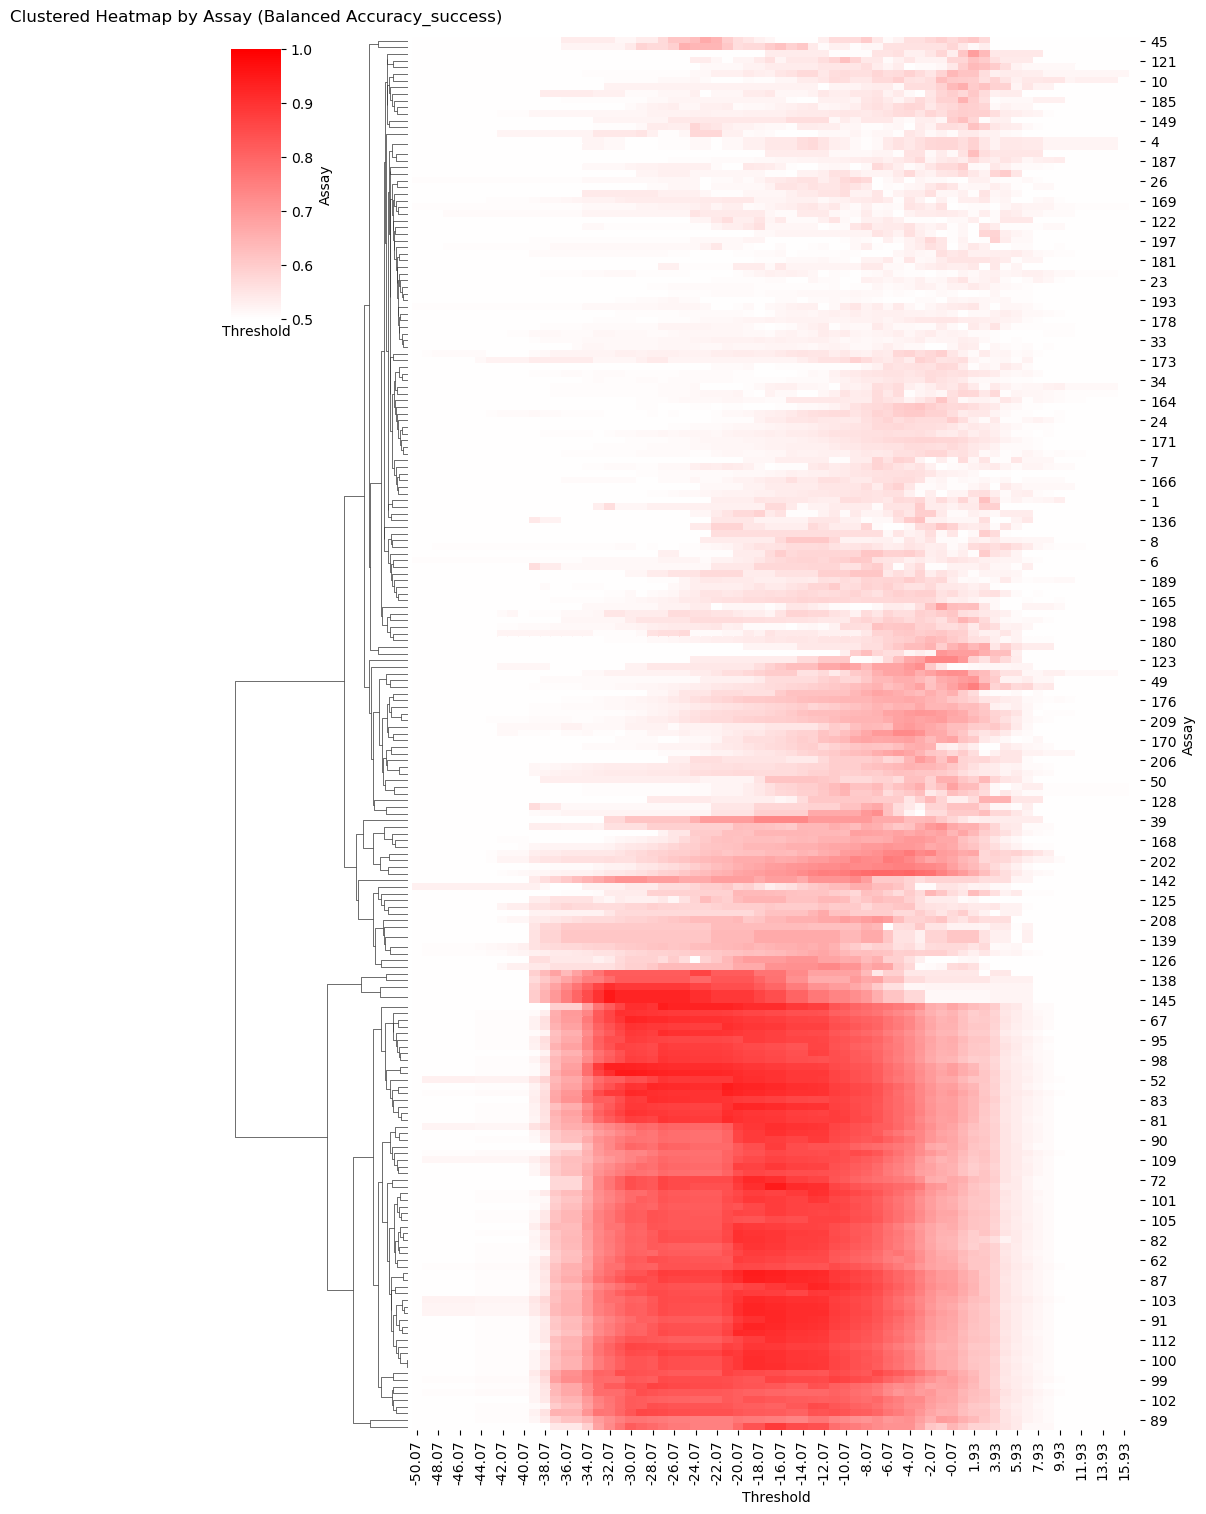

In [24]:
results_df["Balanced Accuracy_success"] = results_df["Balanced Accuracy"].apply(lambda x: 1 - x if x < 0.5 else x)
results_df["AUC_success"] = results_df["AUC"].apply(lambda x: 1 - x if x < 0.5 else x)


custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap, with 'Assay' as rows, 'Threshold' as columns, and 'Balanced Accuracy' as values
heatmap_data = results_df.pivot(index='Assay', columns='Threshold', values='Balanced Accuracy_success')

# Plot the clustered heatmap with clustering only by Assay (rows)
sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
               row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), method='average',
               center=0.5, vmin=0.5, vmax=1)

plt.title('Clustered Heatmap by Assay (Balanced Accuracy_success)', pad=20)
plt.xlabel('Threshold')
plt.ylabel('Assay')
plt.show()


In [80]:
# Define the threshold percentage (e.g., 70%) for "most" of the thresholds
threshold_percentage = 0.4

# Group by Assay and check if more than 70% of the 'Balanced Accuracy_success' values are > 0.6
assays_with_most_ba_success = results_df.groupby('Assay').filter(lambda x: (x['Balanced Accuracy_success'] > 0.75).mean() > threshold_percentage)

# Extract the list of assays
assay_list_most = assays_with_most_ba_success['Assay'].unique()

# Display the list of assays
assay_list_most


array([ 52,  53,  54,  55,  56,  59,  60,  61,  62,  63,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  75,  76,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  90,  91,  92,  93,  95,  96,  98,
        99, 100, 101, 102, 103, 104, 105, 107, 108, 110, 111, 112, 114,
       115])

In [81]:
target_map =  pd.read_csv("../The_Hofmarcher_Files/data/column-assay-index.csv")
target_map = target_map.reset_index()
target_map["index"] = target_map["index"] +1
target_map

,index,ASSAY_ID,CHEMBL_ID
0,1,600885,CHEMBL1040691
1,2,688422,CHEMBL1614544
2,3,688493,CHEMBL1613914
3,4,688810,CHEMBL1613836
4,5,688812,CHEMBL1613838
...,...,...,...
204,205,1301866,CHEMBL3214913
205,206,1301890,CHEMBL3214967
206,207,1301859,CHEMBL3214906
207,208,1301893,CHEMBL3214970


In [82]:
detailed_target_map  = pd.read_csv("../The_Ha_Files/data/output/detailed_target_map.csv")
detailed_target_map

,Unnamed: 0,ASSAY_ID,assay_chembl_id,target_chembl_id,target_type,target_name,organism,gene_symbol
0,0,737823,CHEMBL1741322,CHEMBL3356,SINGLE PROTEIN,Cytochrome P450 1A2,Homo sapiens,CYP1A2
1,1,737824,CHEMBL1741323,CHEMBL3622,SINGLE PROTEIN,Cytochrome P450 2C19,Homo sapiens,CYP2C19
2,2,688422,CHEMBL1614544,CHEMBL1293235,SINGLE PROTEIN,Prelamin-A/C,Homo sapiens,LMNA
3,3,688810,CHEMBL1613836,CHEMBL1615322,NUCLEIC-ACID,microRNA 21,Homo sapiens,TNRC6A
4,4,688812,CHEMBL1613838,CHEMBL1293294,SINGLE PROTEIN,Ras-related protein Rab-9A,Homo sapiens,RAB9A
...,...,...,...,...,...,...,...,...
196,196,1301866,CHEMBL3214913,CHEMBL612545,UNCHECKED,Unchecked,NaN,Unknown
197,197,1301890,CHEMBL3214967,CHEMBL2029197,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 3,Homo sapiens,RAPGEF6
198,198,1301859,CHEMBL3214906,CHEMBL2029198,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 4,Homo sapiens,RAPGEF4
199,199,1301893,CHEMBL3214970,CHEMBL612545,UNCHECKED,Unchecked,NaN,Unknown


In [83]:
target_mapdf = pd.merge(target_map, detailed_target_map, left_on="CHEMBL_ID", right_on="assay_chembl_id").sort_values("index").drop_duplicates(subset=["index"], keep="first").reset_index(drop=True)
target_mapdf

,index,ASSAY_ID_x,CHEMBL_ID,Unnamed: 0,ASSAY_ID_y,assay_chembl_id,target_chembl_id,target_type,target_name,organism,gene_symbol
0,1,600885,CHEMBL1040691,16,600885,CHEMBL1040691,CHEMBL364,ORGANISM,Plasmodium falciparum,Plasmodium falciparum,TRAP
1,2,688422,CHEMBL1614544,2,688422,CHEMBL1614544,CHEMBL1293235,SINGLE PROTEIN,Prelamin-A/C,Homo sapiens,LMNA
2,4,688810,CHEMBL1613836,3,688810,CHEMBL1613836,CHEMBL1615322,NUCLEIC-ACID,microRNA 21,Homo sapiens,TNRC6A
3,5,688812,CHEMBL1613838,4,688812,CHEMBL1613838,CHEMBL1293294,SINGLE PROTEIN,Ras-related protein Rab-9A,Homo sapiens,RAB9A
4,6,688816,CHEMBL1613842,5,688816,CHEMBL1613842,CHEMBL1293232,SINGLE PROTEIN,Survival motor neuron protein,Homo sapiens,Smn1
...,...,...,...,...,...,...,...,...,...,...,...
197,205,1301866,CHEMBL3214913,196,1301866,CHEMBL3214913,CHEMBL612545,UNCHECKED,Unchecked,NaN,Unknown
198,206,1301890,CHEMBL3214967,197,1301890,CHEMBL3214967,CHEMBL2029197,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 3,Homo sapiens,RAPGEF6
199,207,1301859,CHEMBL3214906,198,1301859,CHEMBL3214906,CHEMBL2029198,SINGLE PROTEIN,Rap guanine nucleotide exchange factor 4,Homo sapiens,RAPGEF4
200,208,1301893,CHEMBL3214970,199,1301893,CHEMBL3214970,CHEMBL612545,UNCHECKED,Unchecked,NaN,Unknown


In [84]:
target_mapdf=target_mapdf[target_mapdf.index.isin(assay_list_most)]
target_mapdf

,index,ASSAY_ID_x,CHEMBL_ID,Unnamed: 0,ASSAY_ID_y,assay_chembl_id,target_chembl_id,target_type,target_name,organism,gene_symbol
52,60,809032,CHEMBL1964018,51,809032,CHEMBL1964018,CHEMBL614860,CELL-LINE,SF-539,Homo sapiens,CCT4
53,61,809035,CHEMBL1964021,52,809035,CHEMBL1964021,CHEMBL614922,CELL-LINE,SK-MEL-5,Homo sapiens,WIPI1
54,62,809039,CHEMBL1964025,53,809039,CHEMBL1964025,CHEMBL614021,CELL-LINE,Malme-3M,Homo sapiens,Unknown
55,63,809044,CHEMBL1964030,54,809044,CHEMBL1964030,CHEMBL385,CELL-LINE,K562,Homo sapiens,CEP104
56,64,809048,CHEMBL1964034,55,809048,CHEMBL1964034,CHEMBL614516,CELL-LINE,A498,Homo sapiens,STXBP4
59,67,809057,CHEMBL1964043,58,809057,CHEMBL1964043,CHEMBL614643,CELL-LINE,HOP-62,Homo sapiens,Unknown
60,68,809059,CHEMBL1964045,59,809059,CHEMBL1964045,CHEMBL613829,CELL-LINE,NCI/ADR-RES,Homo sapiens,Unknown
61,69,809061,CHEMBL1964047,60,809061,CHEMBL1964047,CHEMBL615022,CELL-LINE,U-251,Homo sapiens,F3
62,70,809062,CHEMBL1964048,61,809062,CHEMBL1964048,CHEMBL612555,CELL-LINE,OVCAR-8,Homo sapiens,Unknown
63,71,809073,CHEMBL1964059,62,809073,CHEMBL1964059,CHEMBL614164,CELL-LINE,SNB-19,Homo sapiens,cdh-4


In [ ]:
target_mapdf.